In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm

**Comments not up to date yet**

# *Simple univariate example of a normalizing flow*

*Problem description*

Consider the target variable X to be defined as : $$X\sim \mathcal{N}(\mu_X ; \sigma_X)$$ with parameters $$ \mu_X \text{ and } \sigma_X \text{fixed but unknown.} $$ We will use a transformation such that $$ T(u)  = A.u + b $$


In [2]:
#The true values unkown to the simulator
mu_x = 3
sigma_x = 0.5
N = 1000
N_test = 10*N
def gen_observations(number_of_observations:int):
    """Generates a tensor of observations, i.e. x drawn from a normal distribution having mu=mu_x and sigma=sigma_x

    Args:
        number_of_observations (int): Number of obs to generates

    Returns:
        torch.tensor : Tensor of observations
    """  
    #Generating observations from the true distribution
    X = torch.distributions.Normal(loc=mu_x,scale=sigma_x).sample((number_of_observations, ))
    return X
X=gen_observations(N)
X_test = gen_observations(N_test)

In [43]:

class T(nn.Module):
    """Transformation T(u) = A.u + b

    Args:
        None
        
    """
    
    def __init__(self, alpha, b, prior):
        """Init the linear transformer u -> Au +b 

        Args:
            alpha (Float): log(weight)
            b (Float): biais
            prior (torch.distributions): Prior simple to sample from e.g. Normal
        """
        super(T, self).__init__()
        self.b = nn.Parameter(torch.Tensor([b]))
        self.alpha = nn.Parameter(torch.Tensor([alpha]))
        self.prior = prior
    
    def forward(self,x:torch.tensor):
        """Compute the linear transformation Ax + b

        Args:
            x (torch.tensor)

        Returns:
            torch.tensor A*x + b
        """
        
        z = torch.exp(self.alpha) * x + self.b
        return z,self.alpha

    def reverse(self,x):
        return (x-self.b)/(torch.exp(self.alpha))
    
    def L(self, x): 
        """Compute the loss using the change of variable formula
        """
        z,logdet_J = self.forward(x)
        logprob = self.prior.log_prob(self.reverse(x)).mean()
        res =  logdet_J - logprob
        return  res.mean()
    
    def sample(self, size : tuple):
        """Generates U from the prior and returns T(u)

        Args:
            size (tuple): Size of the desired sample. Must be a tuple

        Returns:
            torch.Tensor
        """
        U = self.prior.sample(size)
        z = self.forward(U)[0]
        return z

In [57]:
n_iter = 20000 #Number of iteration
transformation = T( 1, 1, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0]))) #Instanciation #TODO Voir si on instancie loin de la vraie moyenne, temps de CV augmente etc.
learning_rate = 1e-3
optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
optimizer = torch.optim.Adam(transformation.parameters(), learning_rate)

In [58]:
# Keeping records of these values for later visualisations
losses_train = []
estimated_A = []
estimated_b = []

stable_loss = False
epsilon = 1e-4 # IF distance(Loss(test_time_k) ; (test_time_k+1)) < epsilon we stop the training, the convergence is "achieved"
with torch.no_grad():
    previous_loss_test = transformation.L(X_test).mean().detach().item()
    
for i in range(n_iter):
    
    #Computing train loss
    loss_train = transformation.L(X)
    losses_train.append(loss_train.detach().item())
    
    #Optimizaton steps
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    #Keeping records of the estimated parameters
    A_hat, b_hat = torch.exp(transformation.alpha).detach().item(), transformation.b.detach().item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)
    if i%500 == 0:
        print(f"Iter {i}, loss = {loss_train}")
    #Is convergence achieved?
    if i%10 ==0: #We check the convergence every ten iterations
        with torch.no_grad():
            loss_test = transformation.L(X_test).mean().detach().item() #Loss on the test batch
        stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            print(f"Early stop at iteration {i}")
            break
        previous_loss_test = loss_test

Iter 0, loss = 1.9616789817810059
Iter 500, loss = 1.5381172895431519
Iter 1000, loss = 1.1140296459197998
Iter 1500, loss = 0.8028929233551025
Iter 2000, loss = 0.7212985157966614
Early stop at iteration 2220


In [46]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1] 

sample_mean = torch.mean(X)
sample_sigma = torch.std(X, unbiased=False)

print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final training loss = ", losses_train[-1])

 Sample mean = 2.9805562496185303 and b_hat =  2.976245880126953
 Sample std = 0.4954468905925751 and A_hat =  0.49991804361343384
 Final training loss =  0.716762900352478


As expected, the estimated expectation (resp. standard deviation) converges to the sample expectation (resp. standard deviation)

# Visualisation

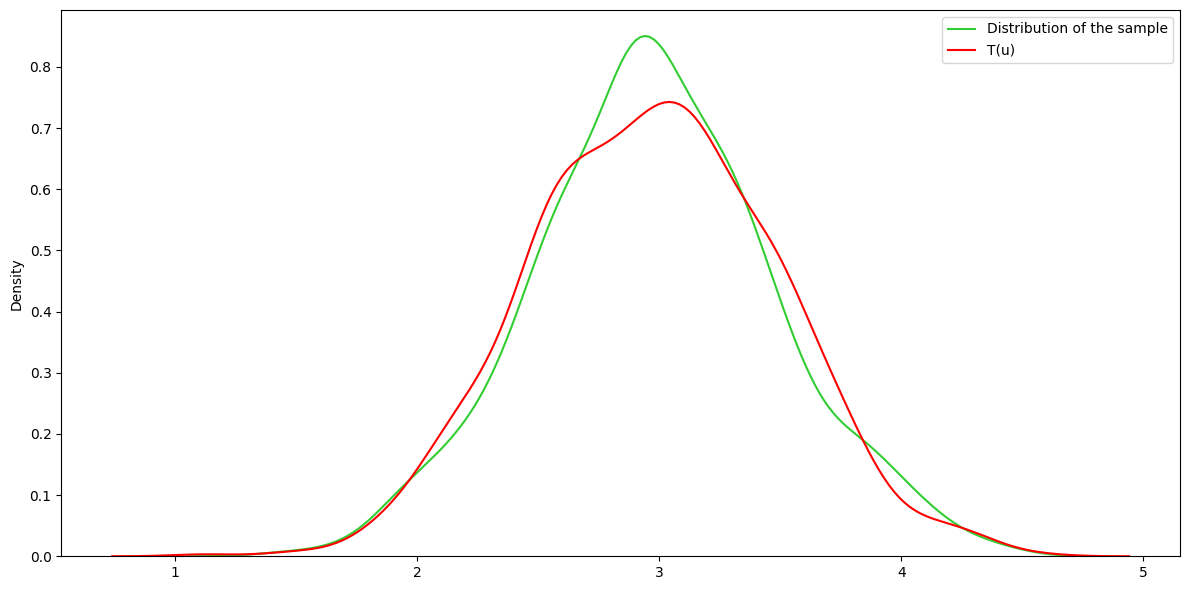

In [50]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation.sample( (N , )).detach().squeeze(), ax = ax, color='red', label='T(u)')


ax.legend()
plt.tight_layout()
plt.show()

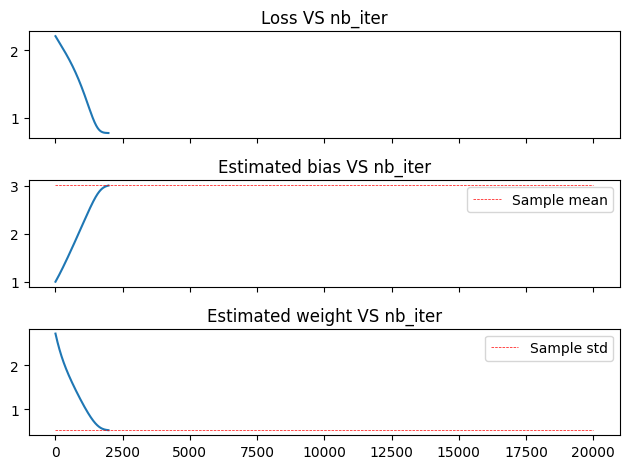

In [61]:
fig, axs = plt.subplots(3, sharex = True)
axs[0].plot(losses_train)
axs[0].set_title("Loss VS nb_iter")
axs[1].plot(estimated_b)
axs[1].hlines(y=sample_mean,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample mean", linestyles='dashed')
axs[1].legend()
axs[1].set_title("Estimated bias VS nb_iter")
axs[2].plot(estimated_A)
axs[2].hlines(y=sample_sigma,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample std", linestyles='dashed')
axs[2].legend()
axs[2].set_title("Estimated weight VS nb_iter")
fig.tight_layout()

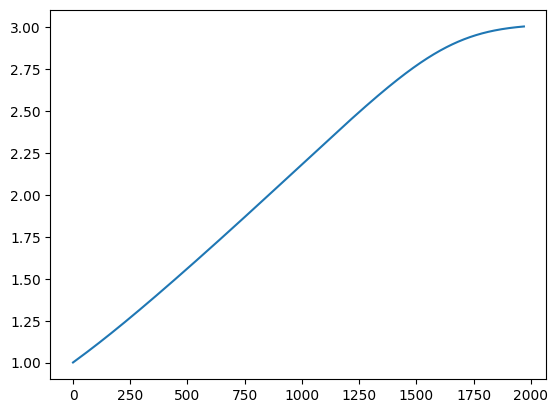

In [62]:
plt.plot(estimated_b)

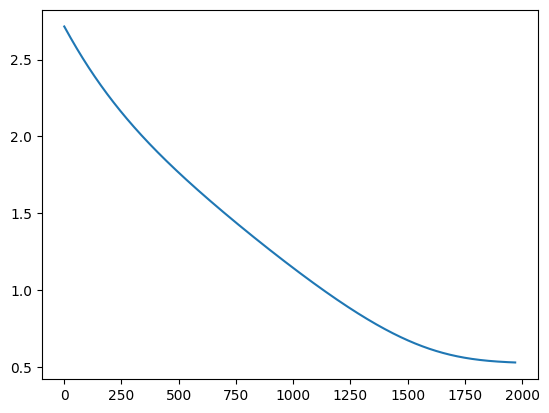

In [63]:
plt.plot(estimated_A)

### Let us compute the loss on a training set

In [64]:
with torch.no_grad():
    loss_t = transformation.L(X_test).mean()
print(loss_t)
losses_train[-1] # Pas grande différence avec la final loss sur le train

tensor(0.7316)


0.7718037962913513

## Effect of sample size

In [4]:
n_iter = 20000 #Number of iteration
transformation = T( 1, 1, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0]))) #Instanciation
learning_rate = 1e-3
optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
optimizer = torch.optim.Adam(transformation.parameters(), learning_rate)

In [29]:
sample_sizes = []
estimated_A_avg = []
estimated_b_avg = []
sample_mean_avg = []
sample_sigma_avg = []
n_iter = 20000
for sample_size in range(10,1000,50): #Size of the observed data
    print(f" Sample size = {sample_size}")
    sample_sizes.append(sample_size) #Saving for later plots

    current_size_A_hat = []
    current_size_b_hat = []
    current_size_sample_mean = []
    current_size_sample_sigma = []
    
    for k in range(10): #We generates observed data 10 times to diminish the randomness, esp. with a small sample size
        X = gen_observations(sample_size)
        X_test = gen_observations(sample_size)
        transformer =T(1, 1, torch.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([1.0])))
        learning_rate = 1e-3
        optimizer = torch.optim.SGD(transformer.parameters(), learning_rate)
        stable_loss = False
        epsilon = 1e-4
        with torch.no_grad():
            previous_loss_test = transformer.L(X_test).mean().detach().item()
        for i in range(n_iter):
            #Computing train loss
            loss_train = transformer.L(X)
            #Optimizaton steps
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            if i%10 ==0: #We check the convergence every ten iterations
                with torch.no_grad():
                    loss_test = transformer.L(X_test).mean().detach().item() #Loss on the test batch
                stable_loss = abs(loss_test - previous_loss_test) < epsilon
            if stable_loss:
                break
            previous_loss_test = loss_test
        current_size_A_hat.append(torch.exp(transformer.alpha).detach().item()) #Saving the estimated A for this particular sample size
        current_size_sample_mean.append(torch.mean(X)) #Saving the sample mean for this particular generation of data, to compare to the estimated b
        current_size_sample_sigma.append(torch.std(X,unbiased=False)) #Saving the sample std for this particular generation of data, to compare to the estimated std
        current_size_b_hat.append(transformer.b.detach().item()) #Saving the estimated b for this particular sample size

    estimated_A_avg.append(np.mean(current_size_A_hat)) #Averaging A over all estimation for the running sample size
    estimated_b_avg.append(np.mean(current_size_b_hat)) #Averaging b over all estimation for the running sample size
    sample_mean_avg.append(np.mean(current_size_sample_mean)) #Averaging the sample mean over all generation of size 'sample_size'
    sample_sigma_avg.append(np.mean(current_size_sample_sigma)) #Averaging the sample std over all generation of size 'sample_size'

 Sample size = 10
 Sample size = 60
 Sample size = 110
 Sample size = 160
 Sample size = 210
 Sample size = 260
 Sample size = 310
 Sample size = 360
 Sample size = 410
 Sample size = 460
 Sample size = 510
 Sample size = 560
 Sample size = 610
 Sample size = 660
 Sample size = 710
 Sample size = 760
 Sample size = 810
 Sample size = 860
 Sample size = 910
 Sample size = 960


In [31]:
dist_b = abs(np.subtract(sample_sigma_avg, estimated_b_avg))
dist_A = abs(np.subtract(estimated_A_avg, sample_mean_avg))

Text(0.5, 1.0, "Distance between weight A and sample std'")

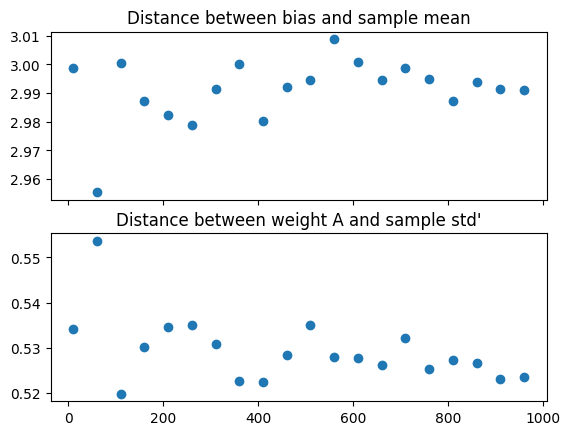

In [32]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(sample_sizes, estimated_b_avg)
#axs[0].set_ylim(-0.5,10)
axs[0].set_title("Distance between bias and sample mean") #Pas très lisible ...
axs[1].scatter(sample_sizes, estimated_A_avg)
#axs[1].set_ylim(-0.5,10)
axs[1].set_title("Distance between weight A and sample std'")


## Effect of initialization

### Mean **Under construction**

In [64]:
learning_rate = 1e-3
distances = [x for x in range(20)]
time_to_conv = []
errors = []
for distance in distances:
    transformation = T(0.0, mu_x+distance, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0])))
    optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
    #Training
    stable_loss = False
    epsilon = 1e-4
    with torch.no_grad():
        previous_loss_test = transformation.L(X_test).mean().detach().item()
    time = n_iter
    for i in range(n_iter):
        #Computing train loss
        loss_train = transformation.L(X)
        #Optimizaton steps
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if i%10 ==0: #We check the convergence every ten iterations
            with torch.no_grad():
                loss_test = transformation.L(X_test).mean().detach().item() #Loss on the test batch
            stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            time = i
            break
        previous_loss_test = loss_test
    time_to_conv.append(time)
    errors.append(torch.abs(transformation.b - torch.mean(X)).item())

In [62]:
time_to_conv

[1700,
 2400,
 4100,
 6720,
 10310,
 14890,
 20000,
 20000,
 20000,
 20000,
 20000,
 1640,
 1480,
 1400,
 1360,
 1330,
 1310,
 1290,
 1280,
 1270]

In [65]:
errors #Apres on bouge plus mais on n'arrive pas au bon res... 

[0.0002720355987548828,
 0.006695985794067383,
 0.00635528564453125,
 0.006316184997558594,
 0.0063135623931884766,
 0.006176948547363281,
 0.029747724533081055,
 2.7512705326080322,
 4.632604598999023,
 6.154226303100586,
 7.5152082443237305,
 10.65170955657959,
 11.689535140991211,
 12.715521812438965,
 13.735132217407227,
 14.751764297485352,
 15.765867233276367,
 16.77855110168457,
 17.78942108154297,
 18.799291610717773]

## What if if X is not gaussian (here chi2)

In [33]:
X_chi = np.random.chisquare(2, N)
X_chi = torch.from_numpy(X_chi)
X_chi = X_chi.reshape(X_chi.size()[0] , 1)
X_chi = X_chi.type(torch.float32)

In [35]:
transformation2 = T( 1, 1, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0]))) #Instanciation
optimizer = torch.optim.SGD(transformation2.parameters(), learning_rate)

In [36]:
losses = []
estimated_A = []
estimated_b = []
for i in range(n_iter):
    #Computing & saving the loss
    loss = transformation2.L(X_chi).mean()
    losses.append(loss.detach().numpy().item())
    #optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Saving parameters for later vizualisation
    A_hat, b_hat = torch.exp(transformation2.alpha).item(), transformation2.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)

In [37]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1]
sample_mean = torch.mean(X_chi)
sample_sigma = torch.std(X_chi, unbiased=True)
print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final loss = ", losses[-1])

 Sample mean = 1.983475923538208 and b_hat =  1.979483723640442
 Sample std = 1.8653315305709839 and A_hat =  1.8644306659698486
 Final loss =  2.041879415512085


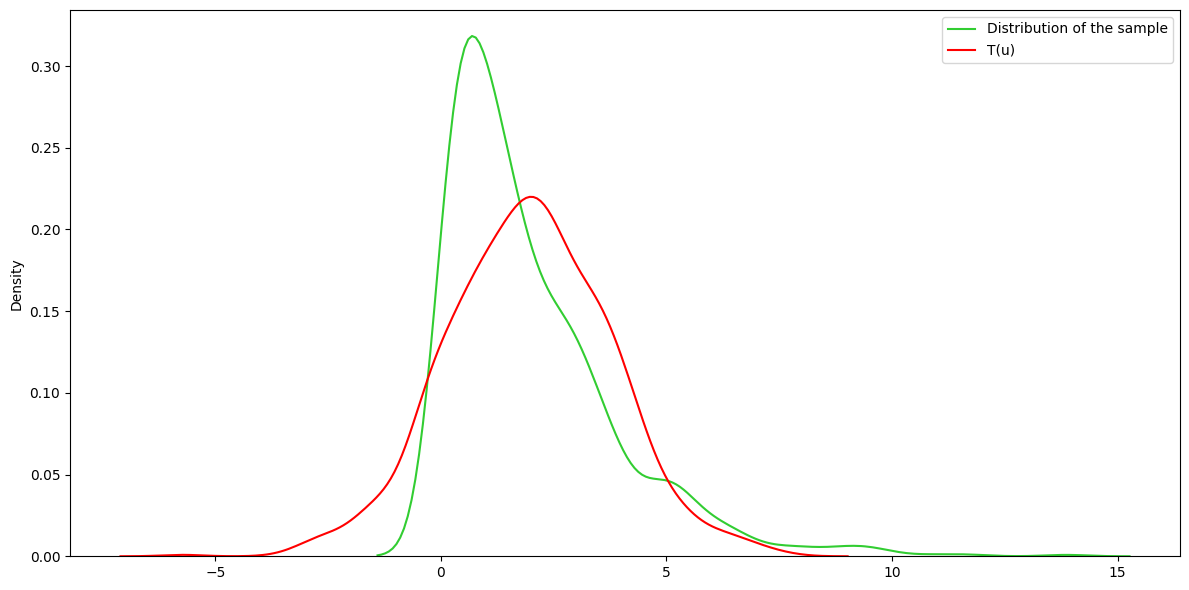

In [40]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X_chi.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation2.forward(U)[0].detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()#TODO Overlayed avec un histo ?

In [ ]:
#TODO Voir si on peut ajouter quelques couches simples en se basant sur la description du papier 
#TODO Objet pour sample, + simple